In [1]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Length based data

In [2]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)

N_s, L_x = 2001, 1000


PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_INFO = PATH+"data_info.npy"
dataInfo = np.load(INPUT_INFO)



################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0

n_data = output.shape[1]
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
output_loss = -np.dot(xx_mask, output) * L_x/N_s




In [3]:
# linear regression model
A = np.ones((n_data, 5))
# sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]

A[:, 0] = inputPara[2, :]
A[:, 1] = inputPara[4, :]
A[:, 2] = inputPara[5, :]
A[:, 3] = inputPara[6, :]

coeff, residuals, _, _ = np.linalg.lstsq(A, output_loss)

print(" linear regression :coeff L_p, x2, x3, h, 1 = ", coeff)
np.mean(  np.abs(np.dot(A, coeff) - output_loss) / output_loss  )


 linear regression :coeff L_p, x2, x3, h, 1 =  [   6729.60701765  -10651.05698545    4432.73592449  -55869.5668772
 1247245.98329811]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


0.1420567207191447

In [4]:
# linear regression model
A = np.ones((n_data, 5))
# sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]

A[:, 0] = inputPara[2, :]
A[:, 1] = inputPara[4, :] - inputPara[2, :]/2.0
A[:, 2] = inputPara[5, :] - inputPara[2, :]/2.0
A[:, 3] = inputPara[6, :]

coeff, residuals, _, _ = np.linalg.lstsq(A, output_loss)

print(" linear regression :coeff L_p, x2, x3, h, 1 = ", coeff)
np.mean(  np.abs(np.dot(A, coeff) - output_loss) / output_loss  )


 linear regression :coeff L_p, x2, x3, h, 1 =  [   3620.44648716  -10651.05698545    4432.73592449  -55869.5668772
 1247245.98329811]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


0.14205672071914482

In [14]:
# fno model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load("catheter_plain_length_model_1d1000", map_location=device)

print(count_params(model))
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
output = torch.tensor(output, dtype=torch.float).permute(1,0)

ntrain = n_data
x_train = input.to(device).reshape(ntrain, N_s, 2)
pred = np.zeros((n_data, N_s))
for i in range(n_data):
    # pred[i, :] = torch.clip(model(x_train[i:i+1,:,:]).squeeze(), min=0.0).detach().cpu().numpy()
    pred[i, :] = model(x_train[i:i+1,:,:].to(device)).detach().cpu().numpy().flatten()
    
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
xx_mask[0:1000] = 0.0
fno_loss = -np.dot(pred, xx_mask) * L_x/N_s

print( np.mean(  np.abs(fno_loss - output_loss) / output_loss  ) )



1336001


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


0.6564729687148131


In [15]:
fno_loss_min_ind = np.argmin(fno_loss)
print(fno_loss[fno_loss_min_ind])
print("sample, uf, L_p, x1, x2, x3, h = ", inputPara[:, fno_loss_min_ind])

np.max(np.abs(fno_loss - output_loss) / output_loss  )

43107.10431863253
sample, uf, L_p, x1, x2, x3, h =  [   1.            5.01469     244.60459564 -122.30229782  -23.1980264
  -80.48276114   20.41438373]


5.137445248758357

369772.4041148986


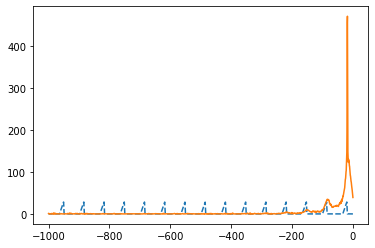

In [16]:
# L_p, x2, x3, h
# fix L_p, h
L_p, x2, x3, h = 66.47064381, -19.95194009, -18.2054513,  28.37515941
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)


X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = -np.dot(out, xx_mask)* L_x/N_s
plt.plot(xx_mask, out)
print(loss)

In [17]:
# L_p, x2, x3, h
# fix L_p, h
L_p, h = 60.0,  30.0
L_p, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(h, dtype=torch.float)

nx2, nx3 = 61, 16
x2_range = np.linspace(-L_p, 0.0, nx2)
x3_range = np.linspace(-15.0, 0.0, nx3)
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(x2_range), len(x3_range)))
for i in range(len(x2_range)):
    for j in range(len(x3_range)):
        x2, x3 = torch.tensor(x2_range[i], dtype=torch.float), torch.tensor(x3_range[j], dtype=torch.float)
        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        
        out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
        
        loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        

Text(0, 0.5, 'x_3')

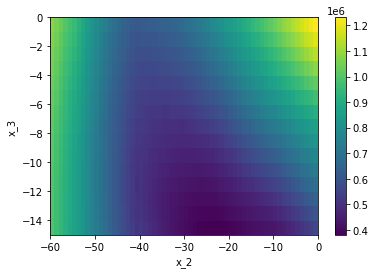

In [18]:
X, Y = np.meshgrid(x2_range ,x3_range)
plt.pcolormesh(X, Y, loss.transpose())
plt.colorbar()
plt.xlabel("x_2")
plt.ylabel("x_3")

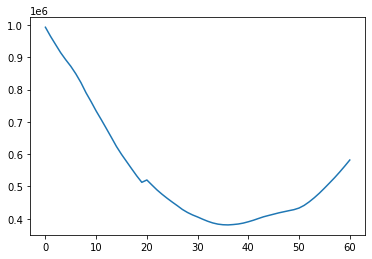

In [19]:
plt.plot(loss[:,0])

sum =  431.60542516047565
dx2_x1 =  5  loss =  262217.19920886634
sum =  346.0650904019765
dx2_x1 =  10  loss =  235515.33082150886
sum =  286.93800837788757
dx2_x1 =  15  loss =  218999.7666667731
sum =  294.71536681329883
dx2_x1 =  20  loss =  222928.70419608892
sum =  322.09862119652456
dx2_x1 =  25  loss =  245830.89629882987
sum =  361.06505040823095
dx2_x1 =  28  loss =  269691.88757916127
sum =  393.2418883085058
dx2_x1 =  30  loss =  286574.73275321024


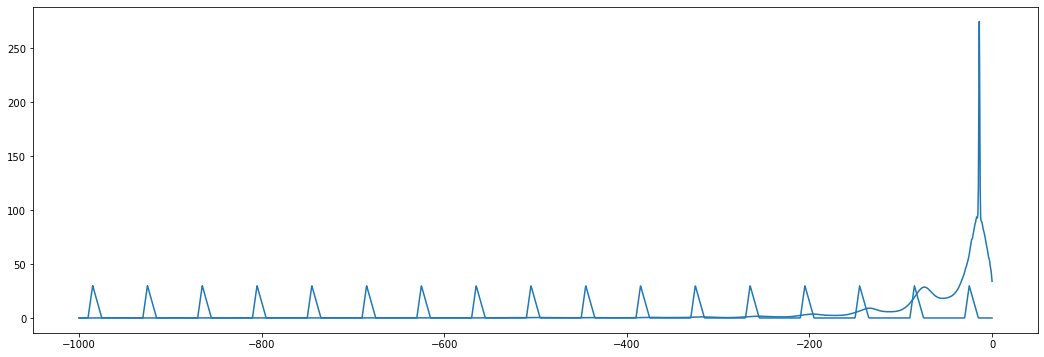

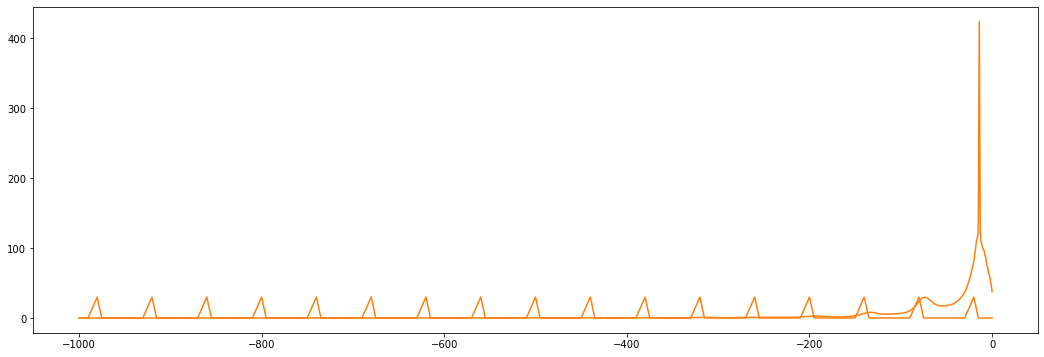

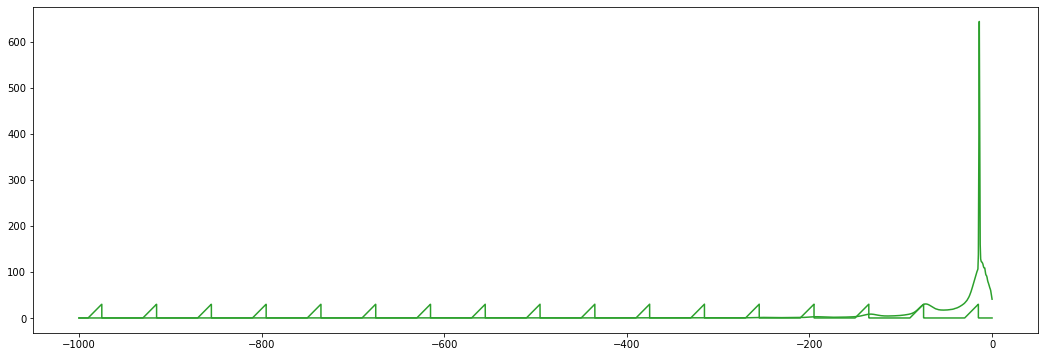

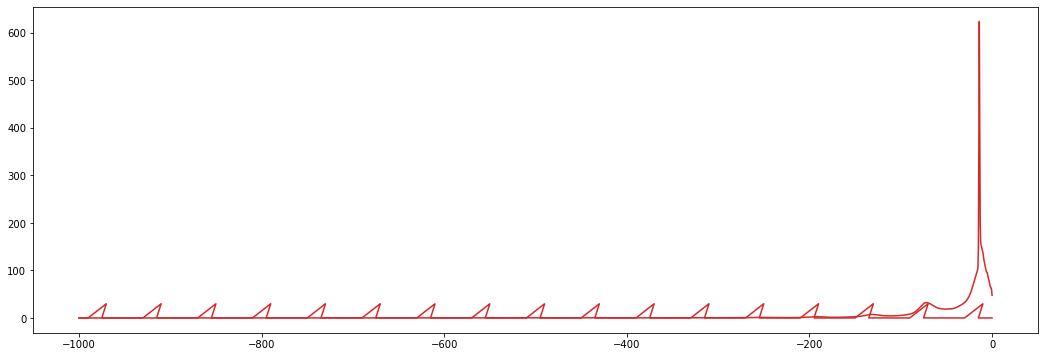

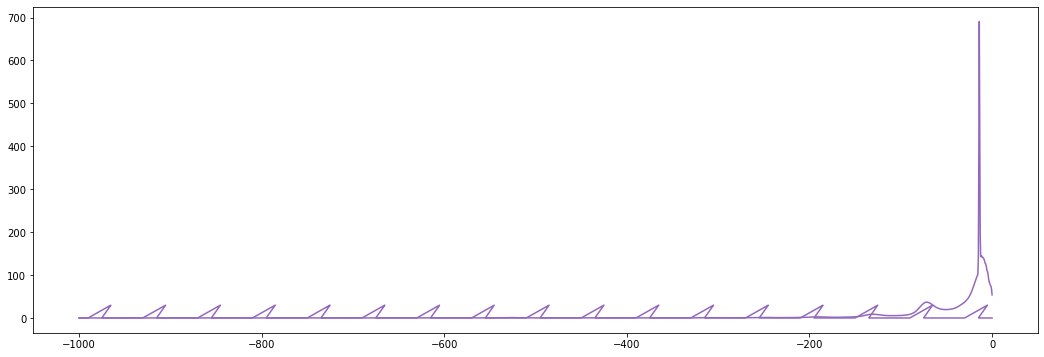

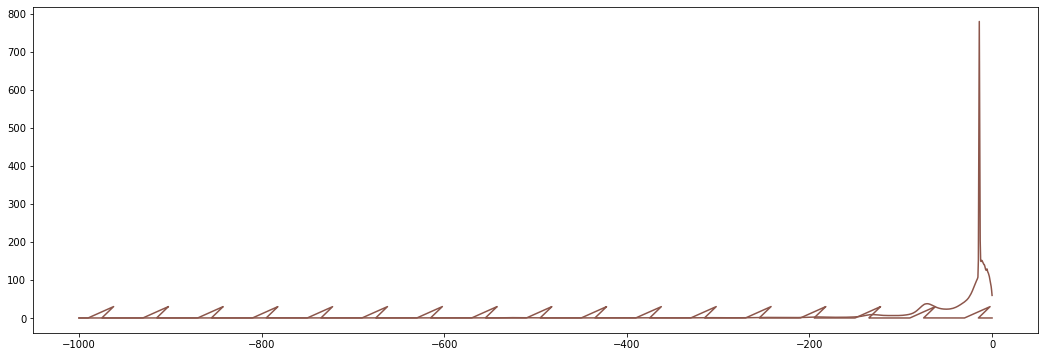

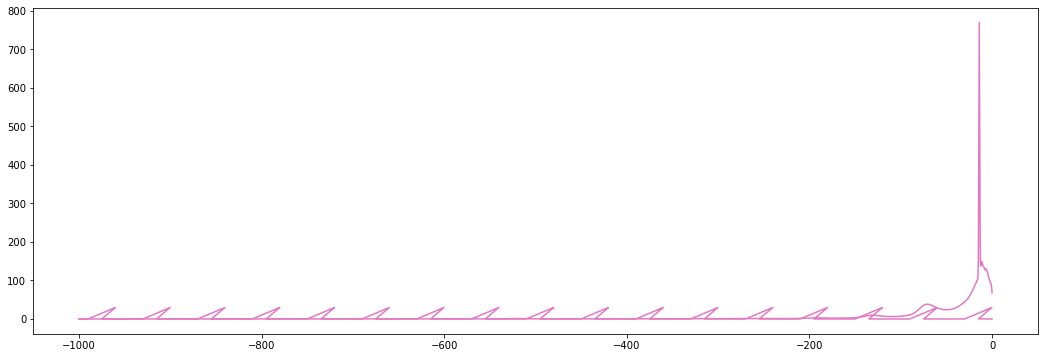

In [20]:
train_data_folder = "/home/tingtaoz/storage/traindatalevy/optimizedtests0906/"

# Study the effect of bw_method
t = 9


N_s, L_x = 2001, 1000
L_p, x1, x3, h = 60.0, -30.0, -15, 30.0
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
dx2_x1_list = [5, 10, 15, 20, 25, 28, 30]

x_mesh, y_mesh = np.zeros((len(dx2_x1_list), N_s)), np.zeros((len(dx2_x1_list), N_s))
density_1d_data_all = np.zeros((len(dx2_x1_list), N_s, 3))
density_1d_data = np.zeros((len(dx2_x1_list), N_s))
for i in range(len(dx2_x1_list)):
    dx2_x1 = dx2_x1_list[i]
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x1+dx2_x1, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/x2_"+str(dx2_x1)+"_U020uf*")
    for file_name in file_names:
        
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)
    print("sum = ", sum(density_1d_data[i, 0:1600]))
    print("dx2_x1 = ",dx2_x1, " loss = ", -np.dot(density_1d_data[i, :], xx)* L_x/N_s)
    plt.figure(figsize=(18,6))
    plt.plot(xx,  density_1d_data[i, :], color="C"+str(i))
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C"+str(i))

# # density 
# plt.figure()
# plt.plot(xx,  density_1d_data)
# plt.plot(x_mesh, y_mesh, color="red")

# # density 
# plt.figure()
# plt.hist(x_b,  bins = 100)
# plt.plot(x_mesh, y_mesh, color="red")


/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf10.0906alpha1.5tauR2_13.2834_15.0299_28.3752.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf15.1359alpha1.5tauR2_13.2834_15.0299_28.3752.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf5.04531alpha1.5tauR2_13.2834_15.0299_28.3752.h5
dx2_x1 =  30  loss =  270201.4345117724


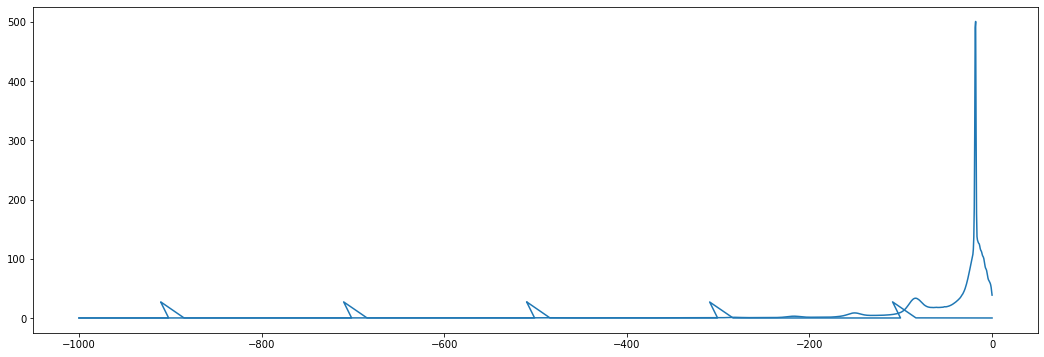

In [21]:
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0823/"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0823/params.txt"
data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
# Study the effect of bw_method
t = 9


N_s, L_x = 2001, 1000
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
samples = [633,]

x_mesh, y_mesh = np.zeros((len(samples), N_s)), np.zeros((len(samples), N_s))
density_1d_data_all = np.zeros((len(samples), N_s, 3))
density_1d_data = np.zeros((len(samples), N_s))
for i in range(len(samples)):
    L_p, x2, x3, h, press = data_info[i - 1, :]
    x1 = -0.5*L_p
    x2 = x1 + x2
    x3 = x1 + x3
    
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/sample"+str(samples[i])+"_U020uf*")
    for file_name in file_names:
        
        print(file_name)
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)

    print("dx2_x1 = ",dx2_x1, " loss = ", -np.dot(density_1d_data[i, :], xx)* L_x/N_s)
    plt.figure(figsize=(18,6))
    plt.plot(xx,  density_1d_data[i, :], color="C"+str(i))
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C"+str(i))

# # density 
# plt.figure()
# plt.plot(xx,  density_1d_data)
# plt.plot(x_mesh, y_mesh, color="red")

# # density 
# plt.figure()
# plt.hist(x_b,  bins = 100)
# plt.plot(x_mesh, y_mesh, color="red")
